In [1]:
!pip install -q torch_snippets # biblioteca com utilidades para pytorch
import torch_snippets
import torch
from torchvision.datasets import MNIST
from torchvision import transforms # módulo com transformadores de imagem
from torch.utils.data import DataLoader
from torch import nn
from torch.optim import AdamW # importa Adam com weight decay
import numpy as np
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
img_transforms = transforms.Compose([ # cria uma pipeline para transformação de imagens
    transforms.ToTensor(), # converte as imagens para tensor
    transforms.Normalize([0.5], [0.5]), # normaliza os valores dos pixels subtraindo a média 0.5 e dividindo pelo desvio padrão 0.5, colocando os valores entre -1 e 1
    transforms.Lambda(lambda x: x.to(device)) # transfere cada imagem para a gpu (se disponivel)
])

In [3]:
data_folder = '/kaggle/working/'
trn_ds = MNIST(data_folder, transform = img_transforms, train = True, download = True) # baixa os dados de treino, já aplicando a pipeline de transformações
val_ds = MNIST(data_folder, transform = img_transforms, train = False, download = True) # baixa os dados de validação, já aplicando a pipeline

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17781714.53it/s]


Extracting /kaggle/working/MNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 467757.76it/s]


Extracting /kaggle/working/MNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4428812.19it/s]


Extracting /kaggle/working/MNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3047596.99it/s]

Extracting /kaggle/working/MNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/MNIST/raw



In [4]:
trn_ds.data.shape, val_ds.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [5]:
# criação dos dataloaders
batch_size = 256
trn_dl = DataLoader(trn_ds, batch_size = batch_size, shuffle = True)
val_dl = DataLoader(val_ds, batch_size = batch_size, shuffle = False)

In [6]:
# criação do construtor da rede autoencoder
class AutoEncoder(nn.Module): # herda de nn.Module
    def __init__(self, latent_dim): # recebe a dimensionalidade do espaço latente
        super().__init__() # inicializa as funcionalidade da classe herdada
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential( # cria a rede de encoder
            nn.Linear(in_features = 28 * 28, out_features = 128),
            nn.ReLU(True), # aplica ReLU inplace, diretamente na estrutura do input
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, latent_dim) # output: latent space
        )
        self.decoder = nn.Sequential( # cria a rede de decoder
            nn.Linear(in_features = latent_dim, out_features = 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28*28), # output: imagem reconstruída, mas ainda planificada
            nn.Tanh() # aplica tangente hiperbólica a imagem
        )
    
    def forward(self, x):
        x = x.view(len(x), -1) # planifica as dimensões de espaço e cor de cada imagem (-1), mantendo o tamanho original do batch (-1)
        x = self.encoder(x) # passa o batch para o processamento paralelo do encoder
        x = self.decoder(x) # passa os tensores codificados com o espaço latente para o decoder processá-los em paralelo
        x = x.view(len(x), 1, 28, 28) # faz o reshape para as dimensõeso originais das imagens
        return x
        

In [7]:
# função de treino com batch
def train_batch(input_, model, loss_fn, opt):
    model.train() # coloca o modelo em modo treino
    opt.zero_grad() # zera o tensor de gradientes do otimizador
    output = model(input_) # aplica encode e decode à imagem
    loss = loss_fn(output, input_) # calcula o erro entre o output e a imagem original
    loss.backward() # calcula os gradientes com backpropagation
    opt.step()
    return loss.item()

# função de validação de batch
@torch.no_grad() # desativa os cálculo de gradiente para chamadas de modelos pytorch na função abaixo
def validate_batch(input_, model, loss_fn):
    model.eval() # coloca o modelo em modo de validação
    output = model(input_) # codifica e decodifica a imagem
    loss = loss_fn(output, input_) # calcula o erro do output com relação a imagem original
    return loss.item()

In [8]:
model = AutoEncoder(3).to(device) # cria um autoencoder para latent spaces de 3 dimensẽos e o armazena no device (e.g gpu)
loss_fn = nn.MSELoss() # cria uma instância de Mean Squared Error para ser o critério de comparação entre inputs e outputs do autoencoder
opt = AdamW(model.parameters(), lr = 1e-3, weight_decay = 1e-5) # cria uma instância de Adam com weight decay para ser o otimizador do autoencoder

num_epochs = 5 # 5 epochs, dado o grande tamanho do dataset
trn_losses, val_losses = [], []

for epoch in range(num_epochs):
    print(epoch)
    trn_batch_losses, val_batch_losses = [], []
    for data, _ in trn_dl: # data: conjunto de imagens do batch; _: classes das imagens, irrelevante para essa aplicação
        loss = train_batch(data, model, loss_fn, opt) # treina o modelo com o batch e captura o erro
        trn_batch_losses.append(loss)
    trn_losses.append(np.array(trn_batch_losses).mean())
    
    for data, _ in val_dl:
        loss = validate_batch(data, model, loss_fn)
        val_batch_losses.append(loss)
    val_losses.append(np.array(val_batch_losses).mean())

0
1
2
3
4


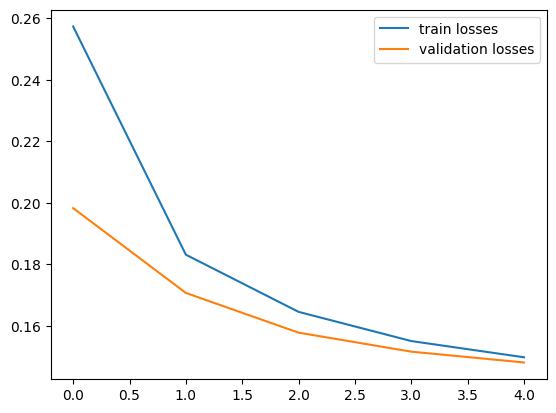

In [9]:
plt.plot(trn_losses, label = 'train losses')
plt.plot(val_losses, label = 'validation losses')
plt.legend()

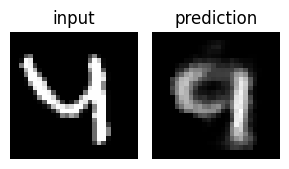

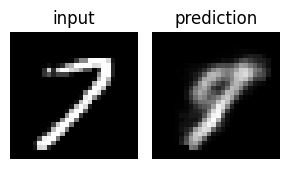

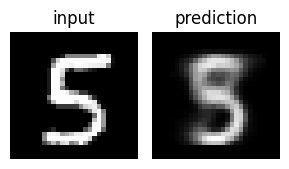

In [10]:
# plotando exemplos
for _ in range(3):
    ix = np.random.randint(len(val_ds)) # pega um índice aleatório do ds de validação
    im, _ = val_ds[ix] # im: imagem; _: classe da imagem, irrelevante para essa aplicação
    _im = model(im[None])[0] # passa a imagem com uma dimensão unitária extra (a de batch), depois retira essa dimensão extra do output
    fig, ax = plt.subplots(1, 2, figsize=(3, 3)) # cria uma figura 3x3 polegadas com 1 linha de 2 subplots
    ax[0].imshow(im[0].cpu().detach().numpy(), cmap='gray') # plota im no primeiro subplot
    ax[0].set_title('input')
    ax[0].axis('off')
    ax[1].imshow(_im[0].cpu().detach().numpy(), cmap = 'gray') # plota _im no segundo plot
    ax[1].set_title('prediction')
    ax[1].axis('off')
    plt.tight_layout() # ajusta o espaçamento dos subplots na figura
    plt.show()
    

In [11]:
# testando multiplas dimensionalidades para o latent space

# função que cria um autoencoder com espaço latent de dimensionalidade latent_dim, o treina, plota erros para dados de treino e validação e o retorna
def train_aec(latent_dim):
    print(f'Dimensionality: {latent_dim}')
    model = AutoEncoder(latent_dim).to(device) # cria uma instância do Auto Encoder com latent space de dimensionalidade latent_dim e o armazena em device
    loss_fn = nn.MSELoss() # define a Mean Square Error como função de custo
    opt = AdamW(model.parameters(), lr = 1e-3, weight_decay = 1e-5) # define o Adam com weight decay como o otimizador a ser usado no modelo
    
    num_epochs = 5 # apenas 5 epochs dado o grande tamanho do dataset
    trn_losses, val_losses = [], []

    
    for epoch in range(num_epochs):
        print(epoch)
        trn_epoch_losses, val_epoch_losses = [], []
        
        for data, _ in iter(trn_dl):
            loss = train_batch(data, model, loss_fn, opt)
            trn_epoch_losses.append(loss)
        trn_losses.append(np.array(trn_epoch_losses).mean())
        
        for data, _ in iter(val_dl):
            loss = validate_batch(data, model, loss_fn)
            val_epoch_losses.append(loss)
        val_losses.append(np.array(val_epoch_losses).mean())

aecs = [train_aec(dim) for dim in [50, 2, 3, 5, 10]]

Dimensionality: 50
0
1
2
3
4
Dimensionality: 2
0
1
2
3
4
Dimensionality: 3
0
1
2
3
4
Dimensionality: 5
0
1
2
3
4
Dimensionality: 10
0
1
2
3
4
